# Convolutional Autoencoders

## Preliminaries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

In [13]:
# In case you are fortunate enough to have access to a GPU...
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset: MNIST

In [2]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
img_size = 28
ds_full = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((img_size,img_size)),
                            torchvision.transforms.ToTensor(),
                            ]))

In [3]:
ds = torch.utils.data.Subset(ds_full, range(1024))

In [4]:
def Draw(x):
    with torch.no_grad():
        plt.imshow(x.squeeze().detach().numpy(), cmap='gray');
        plt.axis('off');

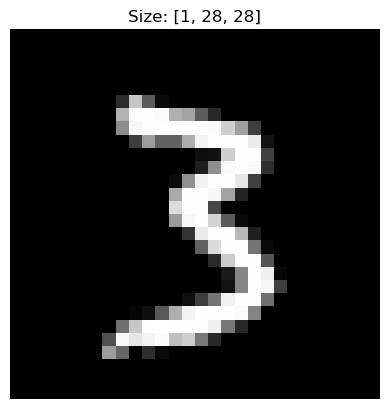

In [5]:
with torch.no_grad():
    x,t = ds.__getitem__(130)
    Draw(x)
    plt.title(f'Size: {list(x.size())}')
plt.show()

## Create some `DataLoader`s

In [27]:
# Batched, for training
batch_size_train = 64
train_dl = torch.utils.data.DataLoader(ds, batch_size=batch_size_train, shuffle=True)

In [28]:
# A single batch, for plotting
train_all = torch.utils.data.DataLoader(ds, batch_size=1024, shuffle=False)

#  `ConvAE` class

In [29]:
class ConvAE(nn.Module):
    '''
     net = ConvAE(img_size=28, embedding_dim=3)
     
     Create a convolutional autoencoder for imput images of size (img_size x img_size),
     with an embedding (latent) layer of (embedding_dim) neurons.
     
     Inputs:
       img_size       size of input images, [1, img_size, img_size]
       embedding_dim  number of nodes in embedding (latent) layer
       
     Usage:
       net = ConvAE()
       y = net(x)
       h = net.encode(x)  # returns latent vectors
    '''
    def __init__(self, img_size=28, embedding_dim=3):
        self.img_size = img_size
        self.embedding_dim = embedding_dim
        self.losses = []
        super().__init__()
        
        # Encoder layer         
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.Flatten(),  # Flatten
            nn.Linear(8 * img_size * img_size, embedding_dim),  # Fully connected dense layer going into latent layer
            nn.Tanh() # to scale latent representations to range is [-1,1]
        )
        
        # Decoder Layer
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 8 * img_size * img_size),  # Fully connected layer
            nn.Unflatten(1, (8, img_size, img_size)),  # Reshape to feature maps
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(16, 64, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # to make sure our output can be pushed in the loss function
        )
        
    def encode(self, x):
        self.h = self.encoder(x) # so we can access latent repr later 
        return self.h
    
    
    def decode(self, x):
        y = self.decoder(x)
        return y
  

    def forward(self, x):
        h = self.encode(x)
        y = self.decode(h)
        return y


# Create and train the network

In [30]:
net = ConvAE(img_size=img_size, embedding_dim=3)

100%|█████████████████████████████████████████| 100/100 [03:29<00:00,  2.09s/it]


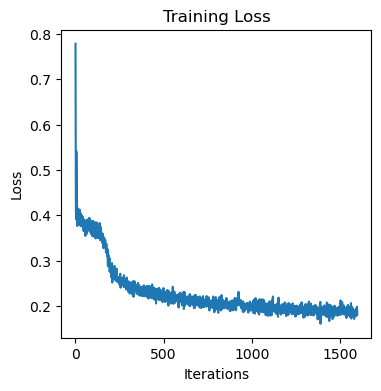

0.18143506348133087


In [31]:
# Train it

# loss function 
loss_fcn = nn.BCELoss(reduction='mean')

# Optimizer used SDG in conjunction with momentum for faster loss convergence
optim = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

def learn(net, train_dl, epochs=100):
    losses = [] 
    for epoch in tqdm(range(epochs)):
        for batch in train_dl:  # Iterate over batches in the DataLoader
            x, _ = batch # we dont really care about labels for now 
            y = net(x)  
            loss = loss_fcn(y, x) # remember the target is the input in an autoencoder
            optim.zero_grad() 
            loss.backward() 
            optim.step() 
            losses.append(loss.item()) 
    plt.figure(figsize=(4,4))
    plt.plot(losses)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()
    print(losses[-1])

learn(net, train_dl)



#  latent space

In [32]:
# Here are 10 colours you can use. But feel free to use others, too.
colour_options = ['k', 'tab:brown', 'r', 'orange', 'gold', 'lawngreen', 'forestgreen', 'blue', 'mediumpurple', 'gray']

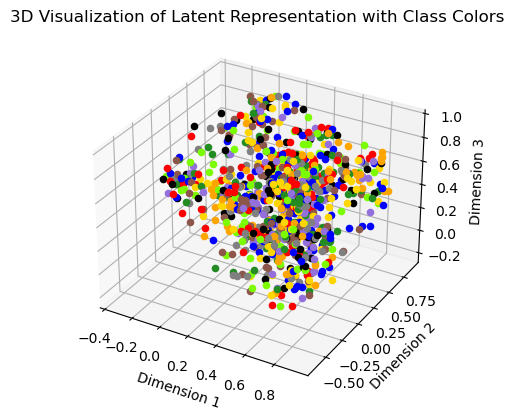

In [33]:
def get_latent_representations(net, data_loader):
    all_h = []
    with torch.no_grad(): 
        for batch in data_loader:
            x, _ = batch
            h = net.encode(x) # uses post training parameters (thats why i couldnt use net.h because i used mini samples)
            all_h.append(h.numpy())
    all_h = np.concatenate(all_h, axis=0)
    return all_h

# getting all labels from all samples
def get_labels():
    all_labels = []
    for _, labels in train_dl:
        all_labels.extend(labels.numpy())
    all_labels = np.array(all_labels)
    return all_labels

# plotting latent representations
def plot_lat(h, labels,colour_options):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for i, (latent_rep, label) in enumerate(zip(h, labels)):
        color = colour_options[label]
        ax.scatter(latent_rep[0], latent_rep[1], latent_rep[2], c=color, label=f'Class {label}')
    
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Dimension 3')
    plt.title('3D Visualization of Latent Representation with Class Colors')
    plt.show()
    

# latent representation of all samples
all_h = get_latent_representations(net, train_dl)

# all labels from data loader
labels = get_labels()

# plot
plot_lat(all_h,labels, colour_options)

# reconstructed digit images

In [24]:
def plot_reconstructed_samples(net, data_loader, num_classes=10):
    fig, axes = plt.subplots(2, num_classes, figsize=(2*num_classes, 4)) # two rows, ten columns
    
    with torch.no_grad():
        for i in range(num_classes):
            # Get first sample from a particular class (randomized)
            for batch in data_loader:
                images, labels = batch
                for image, label in zip(images, labels):
                    if label == i:
                        input_image = image
                        break
                else:
                    continue
                break
            
            # Plot actual image
            axes[0, i].imshow(input_image[0], cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title(f'Class {i} Original')
                
            # Reconstruct image based on network
            reconstructed = net(input_image.unsqueeze(0)).squeeze(0)
            axes[1, i].imshow(reconstructed[0].detach().numpy(), cmap='gray')
            axes[1, i].axis('off')
            axes[1, i].set_title(f'Class {i} Reconstructed')
    
    plt.tight_layout()
    plt.show()

Digit Reconstructions



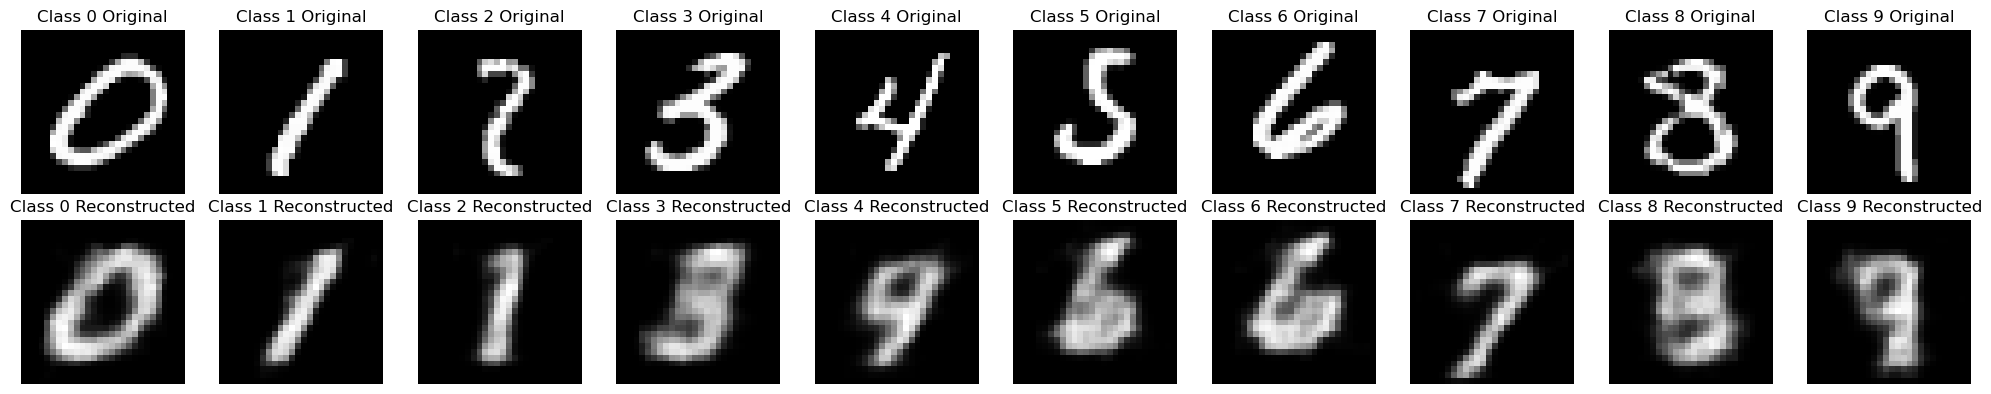

In [34]:
plot_reconstructed_samples(net, train_dl)